In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, r2_score, mean_squared_error, confusion_matrix
import seaborn as sns

In [2]:
# Download data
df = pd.read_csv('Loan_default.csv')

# Data Preparation and some Exploratory

In [3]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [5]:
# View the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [6]:
cat_variables = df.select_dtypes(include = [object])
cat_variables.describe()
# num_varables = df.select_dtypes(include = [])

,LoanID,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
count,255347,255347,255347,255347,255347,255347,255347,255347
unique,255347,4,4,3,2,2,5,2
top,I38PQUQS96,Bachelor's,Part-time,Married,Yes,Yes,Business,Yes
freq,1,64366,64161,85302,127677,127742,51298,127701


In [11]:
cat_variables = cat_variables.drop(columns = ['LoanID'])
for var in cat_variables:
    print(df[var].unique())

["Bachelor's" "Master's" 'High School' 'PhD']
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
['Divorced' 'Married' 'Single']
['Yes' 'No']
['Yes' 'No']
['Other' 'Auto' 'Business' 'Home' 'Education']
['Yes' 'No']


After exploring the unique values of the different categorical variables we notice that education has an order/hierachy. Ordinal encoding (or mapping) could be used for this column. The other columns however do not, so some sort of hot encoding will be best here.

In [14]:
# Print the number counts in each category
for variable in cat_variables:
    print(df[variable].value_counts())
    print("-"*30)

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64
------------------------------
EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64
------------------------------
MaritalStatus
Married     85302
Divorced    85033
Single      85012
Name: count, dtype: int64
------------------------------
HasMortgage
Yes    127677
No     127670
Name: count, dtype: int64
------------------------------
HasDependents
Yes    127742
No     127605
Name: count, dtype: int64
------------------------------
LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64
------------------------------
HasCoSigner
Yes    127701
No     127646
Name: count, dtype: int64
------------------------------


In [15]:
cat_variables['Education'] = cat_variables['Education'].map({"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3})
cat_variables.head()

,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,1,Full-time,Divorced,Yes,Yes,Other,Yes
1,2,Full-time,Married,No,No,Other,Yes
2,2,Unemployed,Divorced,Yes,Yes,Auto,No
3,0,Full-time,Married,No,No,Business,No
4,1,Unemployed,Divorced,No,Yes,Auto,No


### One hot encoding by creating dummy variables (using 0 and 1)

In [17]:
for var in cat_variables.drop(columns = ['Education']):
    encoded = pd.get_dummies(cat_variables[var], prefix = var)
    encoded = encoded.astype(int)
    cat_variables = pd.concat([cat_variables, encoded], axis = 1)
    cat_variables = cat_variables.drop(columns = [var])
cat_variables.head()

,Education,EmploymentType_Full-time,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_No,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1
1,2,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1
2,2,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0
4,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,0


## On to the numerical data

In [18]:
num_variables = df.select_dtypes(include = ('int64', 'float64'))
num_variables.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


### Here we are going to take a look at the boxplot of the numerical variables. This gives us an idea of how the variables are spread out, their range, and if there are any outliers

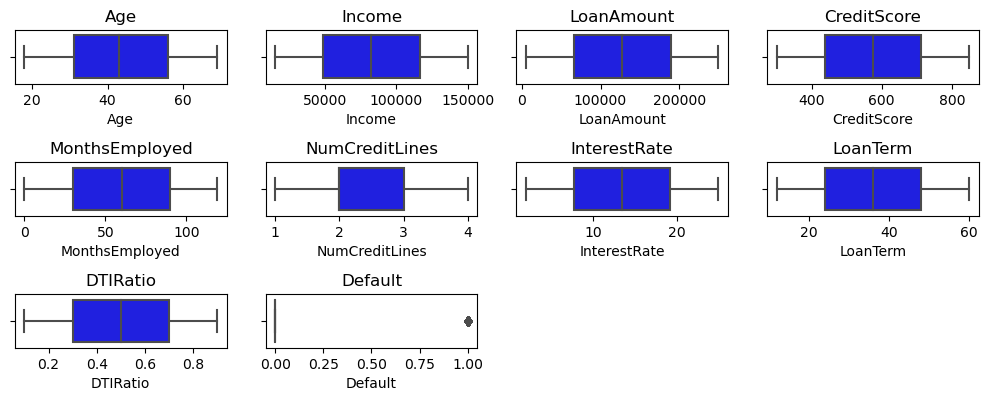

In [21]:
plt.figure(figsize = (10, 5))
n = 1
for var in num_variables:
    plt.subplot(4, 4, n)
    n+=1
    sns.boxplot(x=df[var], color = 'blue')
    plt.title(var)
plt.tight_layout()
plt.show()

### Here we are creating a correlation matrix, with red colors showing high correlation and blue showing low correlation. There does not appear to be any highly correlated variables, so there is no need for adjustments

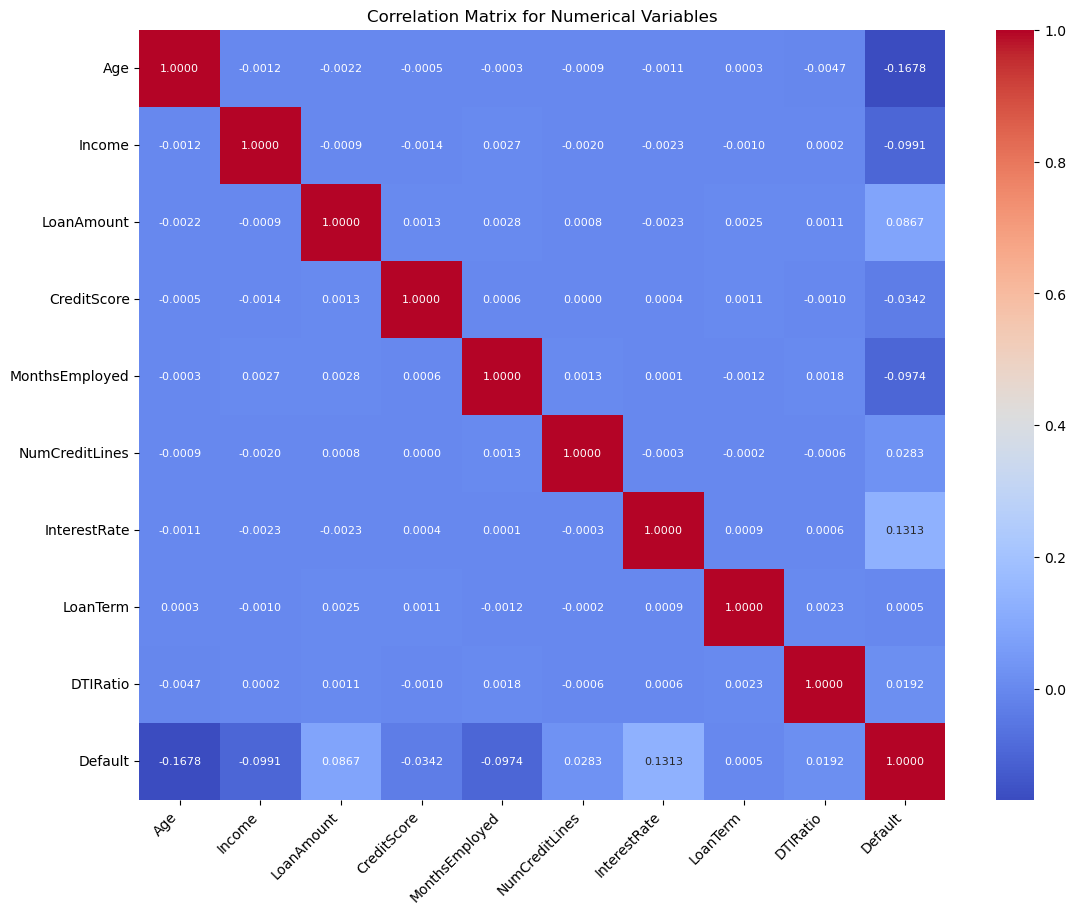

In [32]:
plt.figure(figsize=(13,10))
corr_matrix = num_variables.corr()
heatmap = sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True, fmt = ".4f", annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation =45, ha='right')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

### Using a minmax scaler to get our data to between 0 and 1

In [34]:
scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = scaler.fit_transform(num_variables)
num_variables = pd.DataFrame(x_scaled, columns = num_variables.columns)
num_variables.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,0.745098,0.525885,0.186070,0.400729,0.672269,1.000000,0.575217,0.50,0.4250,0.0
1,1.000000,0.262461,0.487512,0.287796,0.126050,0.000000,0.122174,1.00,0.7250,0.0
2,0.549020,0.512656,0.506892,0.275046,0.218487,0.666667,0.833478,0.25,0.2625,1.0
3,0.274510,0.123801,0.162446,0.806922,0.000000,0.666667,0.220435,0.25,0.1625,0.0
4,0.823529,0.040274,0.016894,0.606557,0.067227,1.000000,0.196087,0.75,0.7875,0.0


In [35]:
# Concatonating the number and categorical variables that we adjusted horizontally (axis = 1)
clean_df = pd.concat([cat_variables, num_variables], axis = 1)
clean_df.head()

,Education,EmploymentType_Full-time,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_No,HasMortgage_Yes,...,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,1,1,0,0,0,1,0,0,0,1,...,0.745098,0.525885,0.186070,0.400729,0.672269,1.000000,0.575217,0.50,0.4250,0.0
1,2,1,0,0,0,0,1,0,1,0,...,1.000000,0.262461,0.487512,0.287796,0.126050,0.000000,0.122174,1.00,0.7250,0.0
2,2,0,0,0,1,1,0,0,0,1,...,0.549020,0.512656,0.506892,0.275046,0.218487,0.666667,0.833478,0.25,0.2625,1.0
3,0,1,0,0,0,0,1,0,1,0,...,0.274510,0.123801,0.162446,0.806922,0.000000,0.666667,0.220435,0.25,0.1625,0.0
4,1,0,0,0,1,1,0,0,1,0,...,0.823529,0.040274,0.016894,0.606557,0.067227,1.000000,0.196087,0.75,0.7875,0.0


# Further Exploratory Data Analysis

### Checking for null values.
No null values here, so no need to drop or fill anything

In [36]:
missing_percentage = (clean_df.isnull().sum()/len(clean_df))
print(missing_percentage)

Education                       0.0
EmploymentType_Full-time        0.0
EmploymentType_Part-time        0.0
EmploymentType_Self-employed    0.0
EmploymentType_Unemployed       0.0
MaritalStatus_Divorced          0.0
MaritalStatus_Married           0.0
MaritalStatus_Single            0.0
HasMortgage_No                  0.0
HasMortgage_Yes                 0.0
HasDependents_No                0.0
HasDependents_Yes               0.0
LoanPurpose_Auto                0.0
LoanPurpose_Business            0.0
LoanPurpose_Education           0.0
LoanPurpose_Home                0.0
LoanPurpose_Other               0.0
HasCoSigner_No                  0.0
HasCoSigner_Yes                 0.0
Age                             0.0
Income                          0.0
LoanAmount                      0.0
CreditScore                     0.0
MonthsEmployed                  0.0
NumCreditLines                  0.0
InterestRate                    0.0
LoanTerm                        0.0
DTIRatio                    

<function matplotlib.pyplot.show(close=None, block=None)>

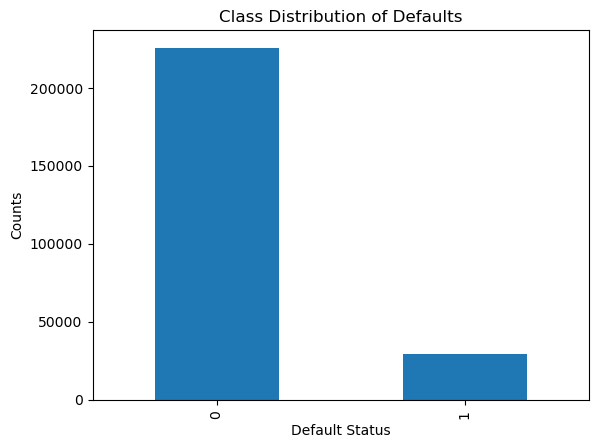

In [37]:
val_counts = df['Default'].value_counts()

val_counts.plot(kind = 'bar')

plt.title('Class Distribution of Defaults')
plt.ylabel('Counts')
plt.xlabel('Default Status')
plt.show

# Fitting Parameters

In [39]:
x, y = clean_df.drop(['Default'], axis = 1), clean_df['Default']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1)
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [40]:
clean_df.head()

,Education,EmploymentType_Full-time,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_No,HasMortgage_Yes,...,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,1,1,0,0,0,1,0,0,0,1,...,0.745098,0.525885,0.186070,0.400729,0.672269,1.000000,0.575217,0.50,0.4250,0.0
1,2,1,0,0,0,0,1,0,1,0,...,1.000000,0.262461,0.487512,0.287796,0.126050,0.000000,0.122174,1.00,0.7250,0.0
2,2,0,0,0,1,1,0,0,0,1,...,0.549020,0.512656,0.506892,0.275046,0.218487,0.666667,0.833478,0.25,0.2625,1.0
3,0,1,0,0,0,0,1,0,1,0,...,0.274510,0.123801,0.162446,0.806922,0.000000,0.666667,0.220435,0.25,0.1625,0.0
4,1,0,0,0,1,1,0,0,1,0,...,0.823529,0.040274,0.016894,0.606557,0.067227,1.000000,0.196087,0.75,0.7875,0.0


### In order to get the best hyperparameters we are using a gridsearch along with a k fold cross validation. Cross validation split up the data into n splits and reserves 1 split for testing data and the rest for training. This repeats n times with a different split reserved for testing each time.

In [41]:
# Random forest parameters
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [20, 40],
    'min_samples_split': [2, 5, 10]
}

# Create a 3 fold cross validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# y_train = y_train.ravel()

rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = rf_params, cv = cv, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 2)
rf.fit(x_train, y_train)
best_params = rf.best_params_
print("Best parameters for Random Forest are:", best_params)
best_score = np.sqrt(-1 * rf.best_score_)
print(best_score)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

In [47]:
print(best_params)
# best_params = {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 500}

In [48]:
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                 max_depth=best_params['max_depth'], 
                                 min_samples_split=best_params['min_samples_split'],
                                 verbose = 5)
best_rf.fit(x_train, y_train)





[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.4s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestRegressor(max_depth=20, min_samples_split=10, verbose=5)

# Can play around with the threshold value
### With a lower threshold value we are classifying more instances as defaulters. As seen below, a threshold value of .25 actually increases the f1 score at the cost of accuracy. Additionally, there are more false positives due to the lower threshold. The ROC will stay constant since it takes into account all thresholds.

In [150]:
# Get the loan predictions for the test dataset
threshold_val = 0.25
y_pred = best_rf.predict(x_test)

y_pred_prob = y_pred
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC: ", auc)

# Turn the probabilities to give us binary output
y_test[y_test < threshold_val] = int(0)
y_test[y_test >= threshold_val] = int(1)
y_test = y_test.astype(int)

y_pred[y_pred < threshold_val] = int(0)
y_pred[y_pred >= threshold_val] = int(1)
y_pred = y_pred.astype(int)
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


AUC:  0.7264716220495518
F1 score: 0.32862234238662896
Accuracy: 0.8288453404765261


In [49]:
# Get the loan predictions for the test dataset
threshold_val = 0.5
y_pred = best_rf.predict(x_test)

y_pred_prob = y_pred

auc = roc_auc_score(y_test, y_pred_prob)


print("AUC: ", auc)

# Turn the probabilities to give us binary output
y_test_binary = y_test
y_test_binary[y_test_binary < threshold_val] = int(0)
y_test_binary[y_test_binary >= threshold_val] = int(1)
y_test_binary = y_test_binary.astype(int)



y_pred_binary = y_pred
y_pred_binary[y_pred < threshold_val] = int(0)
y_pred_binary[y_pred >= threshold_val] = int(1)
y_pred_binary = y_pred_binary.astype(int)

f1 = f1_score(y_test_binary, y_pred_binary)
print("F1 score:", f1)

accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test_binary, y_pred_binary)





[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


AUC:  0.724968752763202
F1 score: 0.1111111111111111
Accuracy: 0.8857089148926172


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


<Axes: >

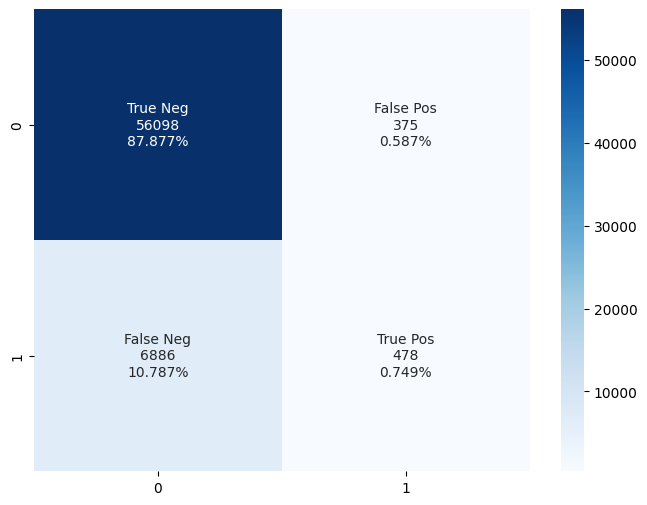

In [155]:
# Code borrowed from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#  Assign classification labels, counts per group and the percentage
classification_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

# Plot the figure, with a heatmap (more value means darker blue)
plt.figure(figsize=(8, 6))
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(classification_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

### We can also print out the total number of counts for the predictions and testing data

In [53]:
# Print the number of counts for each classifaction
counts = np.bincount(y_pred_binary)
print("Total defaulters in our prediction:", counts[1])
print("Total non-defaulters in our prediction:",counts[0])
y_test = y_test.astype(int)

print("-"*50)
count1 = np.bincount(y_test_binary)
print("Total defaulters in our test data:", count1[1])
print("Total non-defaulters in our test data:", count1[0])

Total defaulters in our prediction: 844
Total non-defaulters in our prediction: 62993
--------------------------------------------------
Total defaulters in our test data: 7364
Total non-defaulters in our test data: 56473


In [42]:
# y_train = y_train.ravel()

xgb_params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 5]

}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

xgb = GridSearchCV(estimator = XGBRegressor(random_state = 42), param_grid = xgb_params, cv = cv, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 2)
xgb.fit(x_train, y_train)
best_params_xgb = xgb.best_params_
print("Best parameters for Random Forest are:", best_params_xgb)
best_score_xgb = np.sqrt(-1 * xgb.best_score_)
print(best_score_xgb)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.8s
Best parameters for Random F

In [ ]:
best_params_xgb = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [55]:
best_xgb = XGBRegressor(learning_rate= best_params_xgb['learning_rate'],
                        max_depth = best_params_xgb['max_depth'],
                        n_estimators=best_params_xgb['n_estimators'])
best_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
y_pred_xgb = best_xgb.predict(x_test)

In [67]:
auc = roc_auc_score(y_test, y_pred_xgb)

print("AUC: ", auc)
y_test_binary_xgb = y_test
y_test_binary_xgb = y_test
y_test_binary_xgb[y_test_binary_xgb < threshold_val] = int(0)
y_test_binary_xgb[y_test_binary_xgb >= threshold_val] = int(1)
y_pred_binary_xgb = y_test_binary_xgb.astype(int)



y_pred_binary_xgb = y_pred
y_pred_binary_xgb[y_pred_binary_xgb < threshold_val] = int(0)
y_pred_binary_xgb[y_pred_binary_xgb >= threshold_val] = int(1)
y_pred_binary_xgb = y_pred_binary_xgb.astype(int)

f1 = f1_score(y_test_binary, y_pred_binary_xgb)
print("F1 score:", f1)

accuracy = accuracy_score(y_pred_binary_xgb, y_pred_binary_xgb)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test_binary, y_pred_binary_xgb)

AUC:  0.7526218611936987
F1 score: 0.1111111111111111
Accuracy: 1.0


<Axes: >

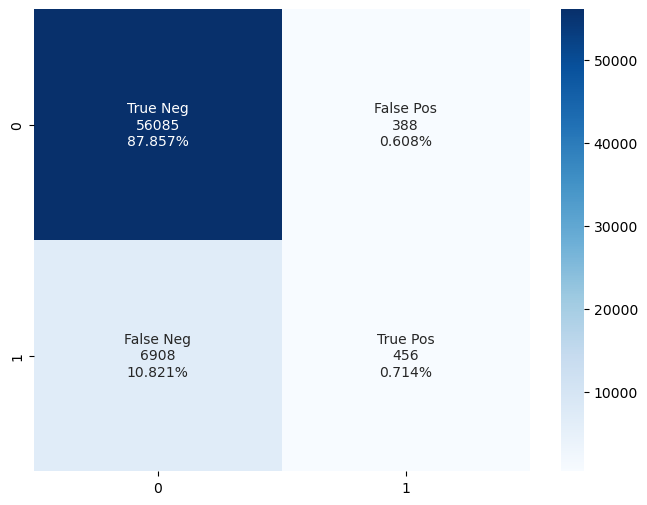

In [69]:
classification_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

# Plot the figure, with a heatmap (more value means darker blue)
plt.figure(figsize=(8, 6))
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(classification_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')